The goal of this notebook is to explore various covariates for microbiome data.


In [98]:
import pandas as pd

from scipy.stats import ranksums, mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [107]:
fotu = "cdi_schubert_results/RDP/cdi_schubert.otu_table.100.denovo.rdp_assigned"
fmeta = "cdi_schubert_results/cdi_schubert.metadata.txt"

#fotu = "ob_goodrich_results/RDP/ob_goodrich.otu_table.100.denovo.rdp_assigned"
#fmeta = "ob_goodrich_results/ob_goodrich.metadata.txt"


rawdf = pd.read_csv(fotu, sep='\t', index_col=0).T
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
meta['DiseaseState'].unique()

array(['nonCDI', 'CDI', 'H'], dtype=object)

In [108]:
def clean_data(otu, meta, labels, sample_reads=1000, otu_reads=10):
    """
    otu, meta : pandas DataFrame
        samples in rows, OTUs/metadata in columns
    labels : list
        list of accepted DiseaseState labels
    sample_reads, otu_reads : int
        min reads per sample/otu
    """
    
    # Keep only samples with the right metadata
    meta = meta.query('DiseaseState == @labels')
    otu = otu.loc[meta.index]
    
    # Remove samples and OTUs without enough reads
    otu = otu[otu.sum(axis=1) >= sample_reads]
    otu = otu.loc[:, otu.sum() >= otu_reads]
    
    meta = meta.loc[otu.index]
    
    return otu, meta

def calculate_pvals(col, ctrl, case):
    return mannwhitneyu(col.loc[ctrl], col.loc[case])

In [109]:
hlabel = 'H'
caselabel = 'CDI'
#caselabel = 'OB'

rawdf, meta = clean_data(rawdf, meta, [hlabel, caselabel])
abundf = rawdf.divide(rawdf.sum(axis=1), axis=0)
abundf.shape

(245, 3267)

In [110]:
ctrl_samples = meta.query('DiseaseState == @hlabel').index
case_samples = meta.query('DiseaseState == @caselabel').index
print(len(ctrl_samples), len(case_samples))

(154, 91)


In [111]:
pvals = abundf.apply(calculate_pvals, args=(ctrl_samples, case_samples)).apply(pd.Series)
pvals.columns = ['stat', 'p']
pvals.head()

,stat,p
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__;d__denovo1106,6342.0,0.013557
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3059,6589.0,0.018634
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3058,6713.0,0.071569
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3051,6951.0,0.390937
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__;d__denovo3050,6788.0,0.063933


In [112]:
## Add some covariates
# Mean reads (across all samples)
covs = pd.merge(pd.DataFrame(rawdf.mean(), columns=['mean_reads']), pvals, left_index=True, right_index=True)

# Detection rate
covs = pd.merge(
    pd.DataFrame((rawdf > 0).sum() / float(rawdf.shape[0]), columns=['ubiquity']),
    covs,
    left_index=True, right_index=True)

# Phylogeny
covs['phylum'] = covs.index.str.split(';').str[1]

covs.head()

,ubiquity,mean_reads,stat,p,phylum
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__;d__denovo1106,0.118367,0.179592,6342.0,0.013557,p__Bacteroidetes
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3059,0.048980,0.057143,6589.0,0.018634,p__Bacteroidetes
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3058,0.048980,0.053061,6713.0,0.071569,p__Bacteroidetes
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3051,0.048980,0.057143,6951.0,0.390937,p__Bacteroidetes
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__;d__denovo3050,0.024490,0.044898,6788.0,0.063933,p__Firmicutes


In [113]:
## Bin covariates
covs['binned_ubiquity'] = pd.qcut(covs['ubiquity'], 4)
covs['binned_meanreads'] = pd.qcut(covs['mean_reads'], 4)
covs.head()

,ubiquity,mean_reads,stat,p,phylum,binned_ubiquity,binned_meanreads
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__;d__denovo1106,0.118367,0.179592,6342.0,0.013557,p__Bacteroidetes,"(0.0816, 0.927]","(0.0939, 0.216]"
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3059,0.048980,0.057143,6589.0,0.018634,p__Bacteroidetes,"(0.0449, 0.0816]","[0.0408, 0.0571]"
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3058,0.048980,0.053061,6713.0,0.071569,p__Bacteroidetes,"(0.0449, 0.0816]","[0.0408, 0.0571]"
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo3051,0.048980,0.057143,6951.0,0.390937,p__Bacteroidetes,"(0.0449, 0.0816]","[0.0408, 0.0571]"
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__;d__denovo3050,0.024490,0.044898,6788.0,0.063933,p__Firmicutes,"[0.00408, 0.0286]","[0.0408, 0.0571]"


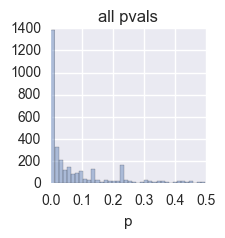

In [114]:
fig, ax = plt.subplots(figsize=(2,2))
sns.distplot(covs['p'], kde=False, ax=ax)
ax.set_title('all pvals')

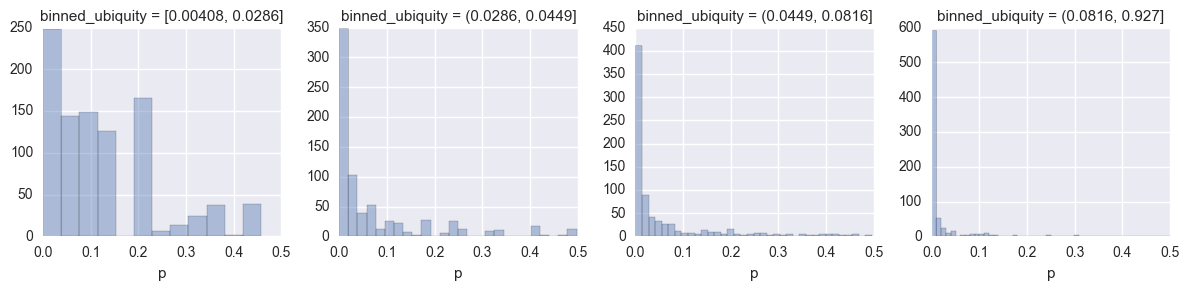

In [115]:
g = sns.FacetGrid(data=covs, col='binned_ubiquity', sharey=False)
g.map(sns.distplot, 'p', kde=False)

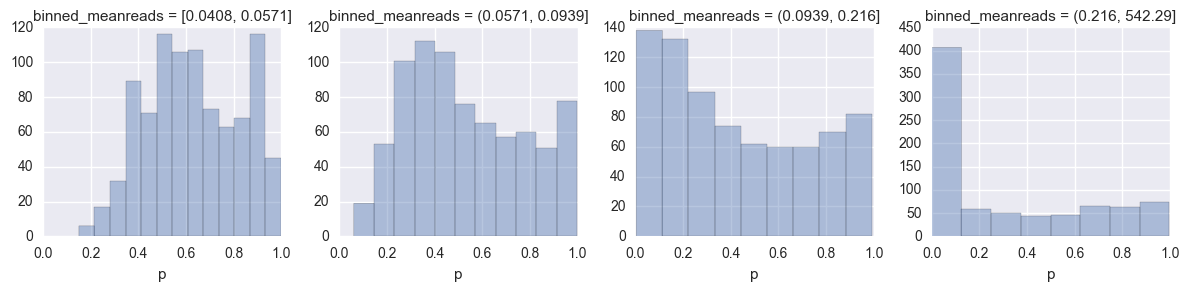

In [77]:
g = sns.FacetGrid(data=covs, col='binned_meanreads', sharey=False)
g.map(sns.distplot, 'p', kde=False)

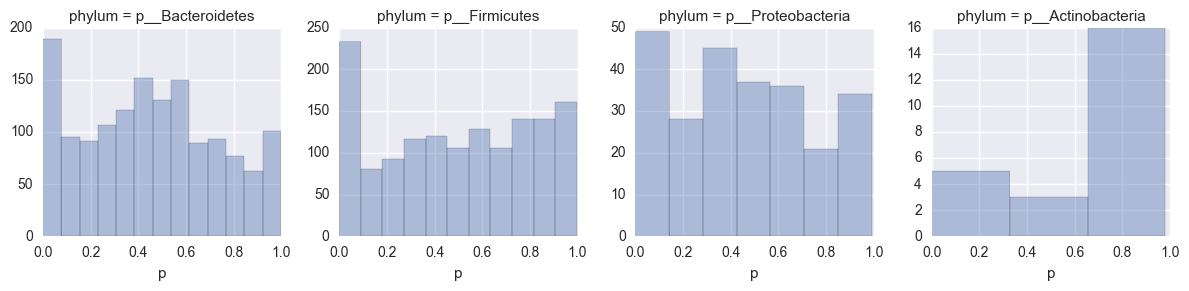

In [80]:
keepphyla = ['p__Actinobacteria', 'p__Bacteroidetes', 'p__Firmicutes', 'p__Proteobacteria']
g = sns.FacetGrid(data=covs.query('phylum == @keepphyla'), col='phylum', sharey=False, col_wrap=4)
g.map(sns.distplot, 'p', kde=False)